In [141]:
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
import torch 
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from torch.nn import functional as F
import scipy.linalg
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [2]:
with open('/home/kitadam/ENR_Sven/moxie/data/processed/pedestal_profiles_ML_READY_ak_19042022.pickle', 'rb') as file:
    massive_dict = pickle.load(file)
    full_dict = massive_dict['ALL']
    massive_dict = {}
    train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids = full_dict['train_dict']['padded']['profiles'],full_dict['train_dict']['padded']['controls'], full_dict['train_dict']['padded']['masks'], full_dict['train_dict']['padded']['radii'] ,full_dict['train_dict']['padded']['real_space_radii'] , full_dict['train_dict']['padded']['pulse_time_ids'] 
    val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids = full_dict['val_dict']['padded']['profiles'],full_dict['val_dict']['padded']['controls'], full_dict['val_dict']['padded']['masks'], full_dict['val_dict']['padded']['radii'], full_dict['val_dict']['padded']['real_space_radii'], full_dict['val_dict']['padded']['pulse_time_ids']
    test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids = full_dict['test_dict']['padded']['profiles'],full_dict['test_dict']['padded']['controls'], full_dict['test_dict']['padded']['masks'], full_dict['test_dict']['padded']['radii'], full_dict['test_dict']['padded']['real_space_radii'], full_dict['test_dict']['padded']['pulse_time_ids']

train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_ids = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_ids = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_ids = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
jet_pedestal_database = pd.read_csv('/home/kitadam/ENR_Sven/moxie/data/processed/jet-pedestal-database.csv')
jet_pedestal_database = jet_pedestal_database[(jet_pedestal_database['FLAG:HRTSdatavalidated'] > 0) & (jet_pedestal_database['FLAG:DEUTERIUM'] == 1)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
FLAGS = [x for x in jet_pedestal_database.columns.to_list() if 'FLAG' in x]

In [3]:
experiment_dict =    {
        "TRIANGULARITY":
            {
                "PULSE_LOW": {'id': 82127, 'value': 0.248164},
                "PULSE_HIGH": {'id': 82647, 'value': 0.377240},
                "annotation": {'text': '$q_{95} = 3.2-3.4$\n$I_{P} = 2$ [MA]\n$B_{T} = 2$ [T]\n$P_{abs} = 10$ [MW]\nV/H divertor', 'xy': (0.68,0.70), "xycoords": 'axes fraction', 'size': 'large'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1200)},
                "mp_dim": 4,
                "ls_dims": [0, 1, 2],
                # "ls_dims": [1, 5, 7],
                "latex": '$\delta$'
            },
        "GASPUFF":
            {
                "PULSE_LOW": {'id': 82130, 'value': 1.12e22},
                "PULSE_HIGH": {'id': 81982, 'value': 6.95e22, "subset": [43]},# Because there are two sets of this, so do subset[0]:
                "annotation": {'text': '$q_{95} = 3.2-3.4$\n$I_{P} = 2$ [MA]\n$B_{T} = 2$ [T]\n$P_{abs} = 10$ [MW]\nV/H divertor\n$\delta=0.27$', 'xy': (0.68,0.70), "xycoords": 'axes fraction'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1400)},
                "latex": '$\Gamma$',
                "ls_dims": [1, 4, 6],
                "mp_dim": -1,
            },
        "NBI_POWER":
            {
                "PULSE_LOW": {'id': 83249, 'value': 26.5},
                "PULSE_HIGH": {'id': 83551, 'value': 17.3},
                "annotation": {'text': '$q_{95} = 3$\n$I_{P} = 2.5$ [MA]\n$B_{T} = 2$ [T]\n$\Gamma = 2-2.5$ [e/s]\nV/H divertor\n$\delta=0.28$', 'xy': (0.65,0.70), "xycoords": 'axes fraction', 'size': 'large'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1400)},
                "latex": '$\Gamma$',
                "ls_dims": [4, 5, 6],
                "mp_dim": -3,
            },
        "CURRENT":
            { # [83603, 96517] 86828, 89087
                "PULSE_LOW": {'id': 83603, 'value': 26.5},
                "PULSE_HIGH": {'id': 96517, 'value': 17.3},
                "annotation": {'text': '$q_{95} = 3$\n$I_{P} = 2.5$ [MA]\n$B_{T} = 2$ [T]\n$\Gamma = 2-2.5$ [e/s]\nV/H divertor\n$\delta=0.28$', 'xy': (0.65,0.70), "xycoords": 'axes fraction', 'size': 'large'},
                "profile_lims": {'PSI_LIM': (0.8, 1.05), 'T_LIM': (-20, 1400)},
                "latex": '$I_P$',
                "ls_dims": [2, 4, 5],
                "mp_dim": 8,
            }
    
    
    }

In [4]:
experiment_name = "TRIANGULARITY" # "TRIANGULARITY", "GASPUFF", "NBI_POWER", "CURRENT"
experiment = experiment_dict[experiment_name]
pulse_low_id, pulse_high_id = experiment['PULSE_LOW']['id'], experiment['PULSE_HIGH']['id']
options = [pulse_low_id, pulse_high_id]
mp_dim = experiment['mp_dim']
ls_dims = experiment['ls_dims']

# Plotting stuffs 
annotation = experiment['annotation']
T_LIM, PSI_LIM = experiment['profile_lims']['T_LIM'], experiment['profile_lims']['PSI_LIM']
QUESTION = experiment_name
print(options)

pulse_1_idxs, pulse_2_idxs = [], []
for n, idx in enumerate(train_pulse_order): 
    if idx == options[0]: 
        pulse_1_idxs.append(n)
    elif idx == options[1]: 
        pulse_2_idxs.append(n)

[82127, 82647]


In [5]:
len(train_pulse_ids), len(val_pulse_ids), len(test_pulse_ids)

(1335, 335, 186)

In [6]:
from moxie.models.DIVA_ak_1 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK

import pytorch_lightning as pl 
model_hyperparams_physics = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 9, 'stoch_latent_dim': 3,
                    'beta_stoch': 0.224, 'beta_mach_unsup':  0.134,'beta_mach_sup':  0.0,
                    'alpha_mach': 78.0, 'alpha_prof': 303.0,
                    'encoder_end_dense_size': 128, 
                    'hidden_dims': [2, 4], 'mp_hdims_cond': [397, 369, 29, 113, 284], 
                    'mp_hdims_aux': [122, 398, 463, 354, 399], 
                    'physics': False, 'gamma_stored_energy': 0.36,
                    'start_sup_time': 1917, 
                    'loss_type': 'semi-supervised'}
model_physics = DIVAMODEL(**model_hyperparams_physics)
model_name_physics = 'DECENT_MODEL_modelstatedict_SCHEDULER_PHYSICS_9MD_3SD_0BMUN_0.0BMSUP_0.224BS_78AM_303AP_128ENCDENSE_100EP_0.03GAMMA'
# model_name = 'modelstatedict_SCHEDULER_PHYSICS_10MD_3SD_0BMUN_0.0BMSUP_2.403BS_11AM_356AP_100EP_0.6GAMMA' # prior [485, 499, 352, 432], cond [212, 306, 26, 295, 263, 336], LD 10, 
state_dict = torch.load('./model_results/{}.pth'.format(model_name_physics))
model_physics.load_state_dict(state_dict['model'])

# For the non physics model
"""
model_hyperparams_no_physics = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 10, 'stoch_latent_dim': 3,
                    'beta_stoch': 8.350, 'beta_mach_unsup':  0.06,'beta_mach_sup':  0.0,
                    'alpha_mach': 42.0, 'alpha_prof': 289.0,  # 212, 306, 26, 295, 263, 336] 	[485, 499, 352, 432]
                    'start_sup_time': 1330,
                     'physics': False, 'gamma_stored_energy': 0.6,
                    'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408], # 'mp_hdims_cond': [397, 369, 29, 113, 284], 'mp_hdims_aux': [122, 398, 463, 354, 399], 
                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised'}
model_no_physics = DIVAMODEL(**model_hyperparams_no_physics)
# experiments/EPED_oder_uns/model_results/modelstatedict_REDUCED_SECULAR_15MD_3SD_1000BMUN_0.001BMSUP_0.001BS_400AM_400AP_128ENCDENSE_50EP.pth
model_name_no_physics = 'DECENT_MODEL_SCHEDULER_SECULAR_10MD_3SD_0BMUN_0.0BMSUP_8.35BS_42AM_289AP_100EP'
state_dict = torch.load('./model_results/modelstatedict_{}.pth'.format(model_name_no_physics))
model_no_physics.load_state_dict(state_dict['model'])
"""

"\nmodel_hyperparams_no_physics = {'in_ch': 2, 'out_length':19,\n                    'mach_latent_dim': 10, 'stoch_latent_dim': 3,\n                    'beta_stoch': 8.350, 'beta_mach_unsup':  0.06,'beta_mach_sup':  0.0,\n                    'alpha_mach': 42.0, 'alpha_prof': 289.0,  # 212, 306, 26, 295, 263, 336] \t[485, 499, 352, 432]\n                    'start_sup_time': 1330,\n                     'physics': False, 'gamma_stored_energy': 0.6,\n                    'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408], # 'mp_hdims_cond': [397, 369, 29, 113, 284], 'mp_hdims_aux': [122, 398, 463, 354, 399], \n                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised'}\nmodel_no_physics = DIVAMODEL(**model_hyperparams_no_physics)\n# experiments/EPED_oder_uns/model_results/modelstatedict_REDUCED_SECULAR_15MD_3SD_1000BMUN_0.001BMSUP_0.001BS_400AM_400AP_128ENCDENSE_50EP.pth\nmodel_name_no_physics = 'DECENT_MODEL_SCHEDULER_SECULAR_10MD_3SD_0BMUN_0.0BMS

In [153]:
# Helper Functions
def de_standardize(x, mu, var): 
    return (x*var) + mu

def standardize(x, mu, var): 
    return (x - mu) / var

def get_preds_pulse(PULSE, model=None): 
    X, PSI, MASK, ID, MPS, _ = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)

    with torch.no_grad(): 
        # Get encoder prediction of X 
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        z_stoch, z_mach = model.reparameterize(mu_stoch, log_var_stoch), model.reparameterize(mu_mach, log_var_mach)
        z_encoder = torch.cat((z_stoch, z_mach), 1)
        
        out_profs_enc = model.p_yhatz(z_encoder)
        out_mp_enc = model.q_hatxzmach(z_mach)
    
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    out_profs_enc[:, 0] = de_standardize(out_profs_enc[:, 0], D_norm, D_var)
    out_profs_enc[:, 1] = de_standardize(out_profs_enc[:, 1], T_norm, T_var)
    return out_profs_enc, out_mp_enc
    
def get_conditional_preds(PULSE, n_samples=100, model=None): 
    X, PSI, MASK, ID, MPS, _ = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)
    MPS = standardize(MPS, MP_norm, MP_var)
    out_profs_cond_all = torch.zeros((n_samples, X.shape[0], X.shape[1], X.shape[2]))
    with torch.no_grad():         
        cond_mu, cond_var =  model.p_zmachx(MPS)
        z_mach = model.reparameterize(cond_mu, cond_var)
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        # z_stoch = model.reparameterize(mu_stoch, log_var_stoch)
        z_stoch = mu_stoch
        z_mach = cond_mu
        z_conditional = torch.cat((z_stoch, z_mach), 1)
        out_profs_cond = model.p_yhatz(z_conditional)
    out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
    out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
        
    """
    for i in range(n_samples): 
        with torch.no_grad():         
            z_stoch = torch.distributions.normal.Normal(0,1).sample((z_mach.shape[0], 3))
            z_conditional = torch.cat((z_stoch, z_mach), 1)
            
            out_profs_cond = model.p_yhatz(z_conditional)
        
        out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
        out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
        
        out_profs_cond_all[i] = out_profs_cond
    """
    MPS = de_standardize(MPS, MP_norm, MP_var)
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    
    return out_profs_cond
    
def from_profiles_find_nesep(PULSE, MODEL_PREDS): 
    profiles_real, PSI, MASK, ID, MPS = PULSE
    profiles_cond, _, _ = MODEL_PREDS
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    # d_profs_enc, t_profs_enc = profiles_enc[:, 0, :], profiles_enc[:, 1, :]
    d_profs_cond, t_profs_cond = profiles_cond[:, 0, :], profiles_cond[:, 1, :]
    # Find point in lorenzo's DB for the pulse
    
    
    tesep_approx_1, tesep_approx_2, nesep_approx_1, nesep_approx_2, psi_approx = np.zeros(len(profiles_cond)), np.zeros(len(profiles_cond)), np.zeros(len(profiles_cond)), np.zeros(len(profiles_cond)), np.zeros(len(profiles_cond))
    for n, (d_prof_real, t_prof_real, rad, mask, d_prof_cond, t_prof_cond) in enumerate(zip(d_profs_real, t_profs_real, PSI, MASK, d_profs_cond, t_profs_cond)): 
        # Want to find point of largest ne gradient, then call that the nesep. 
        """
        d_grad, t_grad, p_grad = np.gradient((1e-19)*d_prof_cond), np.gradient((1e-3)*t_prof_cond), np.gradient((160e-24)*d_prof_cond*t_prof_cond)     
        min_grad_idx_d, min_grad_idx_t, min_grad_idx_p = np.argmin(d_grad), np.argmin(t_grad), np.argmin(p_grad) 
        psi_d, psi_t, psi_p = rad[min_grad_idx_d], rad[min_grad_idx_t], rad[min_grad_idx_p]
        nesep_d, nesep_t, nesep_p = d_prof_cond[min_grad_idx_d], d_prof_cond[min_grad_idx_t], d_prof_cond[min_grad_idx_p]
        nesep_d, nesep_t, nesep_p = torch.mean(d_prof_cond[min_grad_idx_d - 1:min_grad_idx_d + 2]), torch.mean(d_prof_cond[min_grad_idx_t - 1:min_grad_idx_t + 2]), torch.mean(d_prof_cond[min_grad_idx_p - 1:min_grad_idx_p + 2])
        # print('From grad',psi_d, psi_t, psi_p, nesep_d, nesep_t, nesep_p)
        tesep_d, tesep_t, tesep_p = torch.mean(t_prof_cond[min_grad_idx_d - 1:min_grad_idx_d + 2]), torch.mean(t_prof_cond[min_grad_idx_t - 1:min_grad_idx_t + 2]), torch.mean(t_prof_cond[min_grad_idx_p - 1:min_grad_idx_p + 2])
        # print(tesep_d, tesep_t, tesep_p)
        """
        # print('From te close to 100')
        
        close_to_100 = np.argmin(torch.abs(t_prof_cond - 100))
        
        # print(rad[close_to_100], d_prof_cond[close_to_100], t_prof_cond[close_to_100 -2: close_to_100 + 3], torch.mean(t_prof_cond[close_to_100 -2: close_to_100 + 3]), torch.mean(t_prof_cond[close_to_100 -1: close_to_100 + 2]))
        
        tesep_approx_1[n], tesep_approx_2[n] = torch.mean(t_prof_cond[close_to_100 -2: close_to_100 + 3]), torch.mean(t_prof_cond[close_to_100 -1: close_to_100 + 2])
        nesep_approx_1[n], nesep_approx_2[n] = torch.mean(d_prof_cond[close_to_100 -2: close_to_100 + 3]), torch.mean(d_prof_cond[close_to_100 -1: close_to_100 + 2])
        psi_approx[n] = rad[close_to_100]
    return nesep_approx_1, nesep_approx_2, tesep_approx_1, tesep_approx_2, psi_approx
    

def plot_all(PULSE, MODEL_PREDS, plot_params={'id': None, 'title': None, 'model_type': 'Physics', 'annotate_mparams': False}): 
    profiles_real, PSI, MASK, ID, MPS, _ = PULSE
    JPDB_pulse = jet_pedestal_database[jet_pedestal_database['shot'] == ID]
    profiles_cond, profiles_enc, mps_enc = MODEL_PREDS
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    d_profs_enc, t_profs_enc = profiles_enc[:, 0, :], profiles_enc[:, 1, :]
    d_profs_cond, t_profs_cond = profiles_cond[:, 0, :], profiles_cond[:, 1, :]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True, sharex=True)
    mse_ne, mse_te, mse_pe = np.zeros(len(d_profs_real)), np.zeros(len(d_profs_real)), np.zeros(len(d_profs_real))
    for n, (d_prof_real, t_prof_real, rad, mask, d_prof_enc, t_prof_enc, d_prof_cond, t_prof_cond) in enumerate(zip(d_profs_real, t_profs_real, PSI, MASK, d_profs_enc, t_profs_enc, d_profs_cond, t_profs_cond)): 
        
        axs[0].scatter(rad[mask], d_prof_real[mask], c='blue',)
        axs[1].scatter(rad[mask], (1e-3)*t_prof_real[mask], c='blue',)
        axs[2].scatter(rad[mask], (160e-24)*t_prof_real[mask]*d_prof_real[mask], facecolors='none', edgecolors='blue',  label='Real')
        
        
        axs[0].scatter(rad[mask], d_prof_enc[mask], c='salmon',)
        axs[1].scatter(rad[mask], (1e-3)*t_prof_enc[mask], c='salmon',)
        axs[2].scatter(rad[mask], (160e-24)*t_prof_enc[mask]*d_prof_enc[mask], facecolors='none', edgecolors='salmon', label='Encoder')
        
        axs[0].scatter(rad[mask], d_prof_cond[mask], c='green',)
        axs[1].scatter(rad[mask], (1e-3)*t_prof_cond[mask], c='green')
        axs[2].scatter(rad[mask], (160e-24)*t_prof_cond[mask]*d_prof_cond[mask], facecolors='none', edgecolors='green', label='Conditional')
        
        with torch.no_grad(): 
            mse_ne[n] = F.mse_loss((1e-20)*d_prof_cond[mask], (1e-20)*d_prof_real[mask]).item()
            mse_te[n] = F.mse_loss((1e-3)*t_prof_cond[mask], (1e-3)*t_prof_real[mask]).item()
            mse_pe[n] = F.mse_loss((160e-24)*t_prof_cond[mask]*d_prof_cond[mask], (160e-24)*t_prof_real[mask]*d_prof_real[mask]).item()
        if n == 0: 
            axs[2].legend()
       
    if 'neseps' in plot_params.keys():
        if plot_params['neseps'] == None: 
            pass
        else: 
            pred_t100_nesep_1, pred_t100_nesep_2, real_fit_nesep, real_exp_nesep= np.mean(plot_params['neseps'][0]),np.mean(plot_params['neseps'][1]), JPDB_pulse['neseparatrixfromfit10^19(m^-3)'].values[0], JPDB_pulse['error_neseparatrixfromexpdata10^19(m^-3)'].values[0]
            axs[0].vlines(np.mean(plot_params['psis']), 0,0.4e20, ls='--', color='black')
            #  np.mean(plot_params['neseps'][0])
            axs[1].vlines(np.mean(plot_params['psis']), 0, 1, ls='--', color='black', label='$T_{e,sep}$' + '{:.4}'.format(np.mean(plot_params['teseps'][1])))
            #  

            axs[0].annotate(text='$n_{sep, pred1}$=' + '{:.4}'.format(1e-19*pred_t100_nesep_1) + '\n$n_{sep, pred2}$=' + '{:.4}'.format(1e-19*pred_t100_nesep_2)+ '\n$n_{sep, fit}$=' + '{:.4}'.format(real_fit_nesep)+ '\n$n_{sep, exp}$=' + '{:.4}'.format(10*real_exp_nesep), 
                           xy=(0.5, 0.7), xycoords='axes fraction', fontsize='large')
            axs[1].legend()
    if plot_params['annotate_mparams'] == True: 
        LABELS = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
        mean_mp_params = torch.mean(MPS, 0)
        annotation = ''
        for n, label in enumerate(LABELS): 
            mp_lab = mean_mp_params[n]
            annotation += '{}={:.4}\n'.format(label, mp_lab)
            if n == 5: 
                axs[0].annotate(text=annotation, xy=(0.5, 0.55), xycoords='axes fraction',)
                annotation = ''
        axs[1].annotate(text=annotation, xy=(0.5, 0.5), xycoords='axes fraction',)
        pass 
    axs[0].set_title('MSE: {:.4} $\pm$ {:.3}'.format(mse_ne.mean(), mse_ne.std()), size='large')
    axs[0].set_ylabel('$n_e \; \;$ m$^{-3})$', size='xx-large')
    
    axs[1].set_ylabel('$T_e \; \; (keV)$', size='xx-large')
    axs[1].set_title('MSE: {:.4} $\pm$ {:.3}'.format(mse_te.mean(), mse_te.std()), size='large')
    
    axs[2].set_ylabel('$p_e \; \;$ (kPa)', size='xx-large')
    axs[2].set_title('MSE: {:.4} $\pm$ {:.3}'.format(mse_pe.mean(), mse_pe.std()), size='large')
    fig.supxlabel('$\Psi_N$')
    # axs[1].set_ylim(-0.25, 2.5)
    axs[0].set_ylim(-1e19, 1e20)
    # axs[2].set_ylim(-0.25, 10)
    model_type = plot_params['model_type']
    title_params = plot_params['title']
    plt.suptitle(f'Model: {model_type}  Pulse: {ID}  {title_params}')
    plt.show()
def mse(list1, list2): 
    return (np.square(list1, list2)).mean()
def calculate_mse_nesep_for_list_profs(PROFILES, pulse_ids): # PROFILES= val_profiles, val_raddi, val_mask, val_pulses, val_mp_tensors
    profiles, radii, masks, ids, mps, _ = PROFILES 
    
    real_neseps_fit = real_neseps_exp = all_nesep_preds_1 = all_nesep_preds_2 = np.zeros(len(profiles))
    for k in range(len(pulse_ids) - 1):
        
        profiles_real, PSI, MASK, ID, MPS = profiles[pulse_ids[k]], radii[pulse_ids[k]], masks[pulse_ids[k]] > 0, ids[k], mps[pulse_ids[k]]
        
        PROFILE = profiles_real, PSI, MASK, ID, MPS
        JPDB_pulse = jet_pedestal_database[jet_pedestal_database['shot'] == ID]
        
        conditonal_preds = get_conditional_preds(PROFILE, n_samples=200)
        neseps_1, neseps_2, teseps_1, teseps_2, psis = from_profiles_find_nesep(PROFILE, (conditonal_preds, _, _))
        pred_t100_nesep_1, pred_t100_nesep_2, = 1e-19*np.mean(neseps_1),1e-19*np.mean(neseps_2), 
        try: 
            real_fit_nesep, real_exp_nesep = JPDB_pulse['neseparatrixfromfit10^19(m^-3)'].values[0], 10*JPDB_pulse['error_neseparatrixfromexpdata10^19(m^-3)'].values[0]
        except IndexError as e:
            real_fit_nesep, real_exp_nesep = 0.0, 0.0,
            
        all_nesep_preds_1[k] = np.mean(pred_t100_nesep_1)
        all_nesep_preds_2[k] = np.mean(pred_t100_nesep_2)
        real_neseps_fit[k]= real_fit_nesep
        real_neseps_exp[k]= real_exp_nesep
    print(mse(all_nesep_preds_1, real_neseps_exp), mse(all_nesep_preds_2, real_neseps_exp), mse(all_nesep_preds_1, real_neseps_fit), mse(all_nesep_preds_2, real_neseps_fit))
# calculate_mse_nesep_for_list_profs((val_profiles, val_radii, val_mask, val_pulses, val_mp_tensors), val_pulse_ids)

def mtanh(r_vals, h1, h0, p, w, s):
    x = (p-r_vals) / (w/2.0)
    return (h1/2.0 - h0/2.0)*((((1+s*x)*np.exp(x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0
    
def do_curve_fit(x, y, init=None): 
    popt, pcov = curve_fit(mtanh, x, y)
    return popt, pcov
    

def plot_mse_neped(PROFILES, profiles_predictions): 
    profiles_real, radii, masks, ids, mps, real_radii = PROFILES 
    profiles_con = profiles_predictions
    # grab parameters from Jet PDB 
    JPDB_pulse = jet_pedestal_database[jet_pedestal_database['shot'] == ids]
    
    # h1, h0, p, w, s
    initial_guesses_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[0], 0.0,  JPDB_pulse['nepositionRmid(m)'].values[0],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[0],JPDB_pulse['neinnerslope'].values[0], ])
    initial_guesses_te = [JPDB_pulse['Tepedheight(keV)'].values[0], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[0],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[0],JPDB_pulse['Teinnerslope'].values[0], ]
    initial_guesses_pe = [JPDB_pulse['pepedheight(kPa)'].values[0] / 2.0, 0.0,  JPDB_pulse['pepositionRmid(m)'].values[0],0.01*JPDB_pulse['pepedestalwidthRmid(cm)'].values[0],JPDB_pulse['peinnerslope'].values[0], ]
    
    neped_cond_pred, neped_fit_real, neped_lorenzo, neped_uncert = np.zeros(len(profiles_con)), np.zeros(len(profiles_con)), initial_guesses_ne[0], JPDB_pulse['error_nepedheight10^19(m^-3)'].values[0]
    teped_cond_pred, teped_fit_real, teped_lorenzo, teped_uncert = np.zeros(len(profiles_con)), np.zeros(len(profiles_con)), initial_guesses_te[0], JPDB_pulse['error_Tepedheight(keV)'].values[0]
    peped_cond_pred, peped_fit_real, peped_lorenzo, peped_uncert = np.zeros(len(profiles_con)), np.zeros(len(profiles_con)), initial_guesses_pe[0], JPDB_pulse['error_pepedheight(kPa)'].values[0]
    
    # conditional predictions
    d_profs_con, t_profs_con = profiles_con[:, 0, :], profiles_con[:, 1, :]
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True, sharex=True)
    for n, (d_prof, t_prof, rad, mask, d_prof_real, t_prof_real) in enumerate(zip(d_profs_con, t_profs_con, real_radii, masks, d_profs_real, t_profs_real)):
        xdata = rad[mask]
        # xdata = np.linspace(3.75, 3.9, len(rad[mask]))
        xdata_fit = np.linspace(3.75, 3.9, 50)
        ydata_d = d_prof[mask]*1e-19
        ydata_t = t_prof[mask] / 1000.0
        
        ydata_d_real = d_prof_real[mask]*1e-19
        ydata_t_real = t_prof_real[mask] / 1000.0
        # print('h1', 'h0', 'p', 'w', 's')
        # print(initial_guesses_ne)
        # print(initial_guesses_te)
        # print('mtanh fit for ne from JET PDB')
        # print(ydata_d, xdata, mtanh(xdata, *initial_guesses_ne))
        
        popt_d, pcov_d = curve_fit(mtanh, xdata, ydata_d, p0 = initial_guesses_ne, maxfev = 10000)
        popt_t, pcov_t = curve_fit(mtanh, xdata, ydata_t, p0 = initial_guesses_te, maxfev = 10000)
        popt_p, pcov_p = curve_fit(mtanh, xdata, ydata_t*ydata_d, p0 = initial_guesses_pe, maxfev = 10000)
        
        popt_d_real, pcov_d_real = curve_fit(mtanh, xdata, ydata_d_real, p0 = initial_guesses_ne, maxfev = 10000)
        popt_t_real, pcov_t_real = curve_fit(mtanh, xdata, ydata_t_real, p0 = initial_guesses_te,  maxfev = 10000)
        
        popt_p_real, pcov_p_real = curve_fit(mtanh, xdata, ydata_d_real*ydata_t_real, p0 = initial_guesses_pe, maxfev = 10000)
        
        
        neped_cond_pred[n] = popt_d[0]
        neped_fit_real[n] = popt_d_real[0]
        
        teped_cond_pred[n] = popt_t[0]
        teped_fit_real[n] = popt_t_real[0]
        
        
        # print(popt_d)
        # print(popt_d_real)
        # print(popt_t)
        
        axs[0].plot(xdata_fit, mtanh(xdata_fit, *initial_guesses_ne), label='JPDB Fit', color='blue')
        axs[0].scatter(xdata, ydata_d, label='Cond. Pred', color='red')
        axs[0].scatter(xdata, 1e-19*d_prof_real[mask], label='Real', color='purple')
        axs[0].plot(xdata_fit, mtanh(xdata_fit, *popt_d), label='Cond. Fit', color='green')
        axs[0].plot(xdata_fit, mtanh(xdata_fit, *popt_d_real), label='Real Fit', color='black')
        
        axs[1].plot(xdata_fit, mtanh(xdata_fit, *initial_guesses_te), color='blue')
        axs[1].scatter(xdata, ydata_t, color='red')
        axs[1].scatter(xdata, 1e-3*t_prof_real[mask], color='purple')
        axs[1].plot(xdata_fit, mtanh(xdata_fit, *popt_t), label='Cond. Fit', color='green')
        axs[1].plot(xdata_fit, mtanh(xdata_fit, *popt_t_real), label='Real Fit', color='black')
        # axs[1].annotate(text='Compare both', xy=(0.65, 0.5), xycoords='axes fraction',)
        
        axs[1].plot(xdata_fit, mtanh(xdata_fit, *initial_guesses_te), color='blue')
        
        axs[2].plot(xdata_fit, mtanh(xdata_fit, *initial_guesses_pe), color='blue')
        axs[2].scatter(xdata, ydata_t*ydata_d, color='red')
        axs[2].scatter(xdata, 1e-3*t_prof_real[mask]*1e-19*d_prof_real[mask], color='purple')
        axs[2].plot(xdata_fit, mtanh(xdata_fit, *popt_p), label='Cond. Fit', color='green')
        axs[2].plot(xdata_fit, mtanh(xdata_fit, *popt_p_real), label='Real Fit', color='black')
        
        # print(popt_d, popt_t)
        # print(initial_guesses_ne, initial_guesses_te)
        if n == 0: 
            axs[0].legend()
    axs[0].annotate('AVG Height\npred={:.3}+-{:.3}\nfit={:.3}+-{:.3}\nfras={:.3}+-{:.3}'.format(neped_cond_pred.mean(), neped_cond_pred.std(), neped_fit_real.mean(),neped_fit_real.std(), neped_lorenzo, neped_uncert), fontsize='small', xy=(0.1,0.1), xycoords='axes fraction')
    axs[1].annotate('AVG Height\npred={:.3}+-{:.3}\nfit={:.3}+-{:.3}\nfras={:.3}+-{:.3}'.format(teped_cond_pred.mean(), teped_cond_pred.std(), teped_fit_real.mean(),teped_fit_real.std(), teped_lorenzo, teped_uncert), fontsize='small', xy=(0.75,0.75), xycoords='axes fraction')

    axs[0].set_ylabel('$n_e \; \;$ m$^{-3})$', size='xx-large')    
    axs[1].set_ylabel('$T_e \; \; (keV)$', size='xx-large')
    
    # axs[2].set_ylabel('$p_e \; \;$ (kPa)', size='xx-large')
    # axs[2].set_title('MSE: {:.4} $\pm$ {:.3}'.format(mse_pe.mean(), mse_pe.std()), size='large')
    fig.supxlabel('$R_{mid}$')
    
    return (neped_cond_pred.mean(), neped_fit_real.mean(), neped_lorenzo)

plt.close('all')
k = 6

    
k = 25
PULSE_val_sample = val_profiles[val_pulse_ids[k]], val_radii[val_pulse_ids[k]], val_mask[val_pulse_ids[k]] > 0, val_pulses[k], val_mp_tensors[val_pulse_ids[k]], val_real_space_radii[val_pulse_ids[k]]
PULSE_val_conditional = get_conditional_preds(PULSE_val_sample, n_samples=200, model=model_physics)
PULSE_val_enc, MP_val_enc = get_preds_pulse(PULSE_val_sample, model=model_physics)
mean_neped_cond, mean_neped_real, neped_frassineti = plot_mse_neped(PULSE_val_sample, PULSE_val_conditional)
print(mean_neped_cond, mean_neped_real, neped_frassineti)

/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_30590/1166909090.py:202: RuntimeWarning: overflow encountered in exp
  return (h1/2.0 - h0/2.0)*((((1+s*x)*np.exp(x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0
/tmp/ipykernel_30590/1166909090.py:202: RuntimeWarning: invalid value encountered in true_divide
  return (h1/2.0 - h0/2.0)*((((1+s*x)*np.exp(x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

In [ ]:
def calculate_ped_heights(PROFILES, profiles_predictions): 
    profiles_real, radii, masks, ids, mps, real_radii = PROFILES 
    profiles_con = profiles_predictions
    # grab parameters from Jet PDB 
    JPDB_pulse = jet_pedestal_database[jet_pedestal_database['shot'] == ids]
    
    # h1, h0, p, w, s
    initial_guesses_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[0], 0.0,  JPDB_pulse['nepositionRmid(m)'].values[0],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[0],JPDB_pulse['neinnerslope'].values[0], ])
    initial_guesses_te = np.array([JPDB_pulse['Tepedheight(keV)'].values[0], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[0],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[0],JPDB_pulse['Teinnerslope'].values[0], ])
    initial_guesses_pe = np.array([JPDB_pulse['pepedheight(kPa)'].values[0] / 2.0, 0.0,  JPDB_pulse['pepositionRmid(m)'].values[0],0.01*JPDB_pulse['pepedestalwidthRmid(cm)'].values[0],JPDB_pulse['peinnerslope'].values[0], ])
    
    cond_pred_fit_params, real_fit_params = np.zeros((3, 5, len(profiles_con))), np.zeros((3, 5, len(profiles_con)))
    neped_cond_pred, neped_fit_real, neped_lorenzo = np.zeros(len(profiles_con)), np.zeros(len(profiles_con)), initial_guesses_ne[0]
    # conditional predictions
    d_profs_con, t_profs_con = profiles_con[:, 0, :], profiles_con[:, 1, :]
    d_profs_real, t_profs_real = profiles_real[:, 0, :], profiles_real[:, 1, :]
    
    
    for n, (d_prof, t_prof, rad, mask, d_prof_real, t_prof_real) in enumerate(zip(d_profs_con, t_profs_con, real_radii, masks, d_profs_real, t_profs_real)):
        xdata = rad[mask]
        
        xdata_fit = np.linspace(3.7, 3.9, 50)
        ydata_d = d_prof[mask]*1e-19
        ydata_t = t_prof[mask] / 1000.0
        
        ydata_d_real = d_prof_real[mask]*1e-19
        ydata_t_real = t_prof_real[mask] / 1000.0

        try: 
            popt_d, pcov_d = curve_fit(mtanh, xdata, ydata_d, p0 = initial_guesses_ne, maxfev = 10000)
            popt_t, pcov_t = curve_fit(mtanh, xdata, ydata_t, p0 = initial_guesses_te, maxfev = 10000)
            popt_p, pcov_p = curve_fit(mtanh, xdata, ydata_t*ydata_d, p0 = initial_guesses_pe, maxfev = 10000)
            
        except RuntimeError as e: 
            popt_d, popt_t, popt_p = [np.nan]*5, [np.nan]*5, [np.nan]*5
            
        try: 
            popt_d_real, pcov_d_real = curve_fit(mtanh, xdata, ydata_d_real, p0 = initial_guesses_ne, maxfev = 10000)
            popt_t_real, pcov_t_real = curve_fit(mtanh, xdata, ydata_t_real, p0 = initial_guesses_te, maxfev = 10000)
            popt_p_real, pcov_p_real = curve_fit(mtanh, xdata, ydata_d_real*ydata_t_real, p0 = initial_guesses_pe, maxfev = 10000)
        
        except RuntimeError as e: 
            popt_d_real, popt_t_real, popt_p_real = [np.nan]*5, [np.nan]*5, [np.nan]*5
        
        cond_pred_fit_params[0, :, n] = popt_d
        cond_pred_fit_params[1, :, n] = popt_t
        cond_pred_fit_params[2, :, n] = popt_p
        
        real_fit_params[0, :, n] = popt_d_real
        real_fit_params[1, :, n] = popt_t_real
        real_fit_params[2, :, n] = popt_p_real
        
        
        neped_cond_pred[n] = popt_d[0]
        neped_fit_real[n] = popt_d_real[0]
    initial_guesses_pe[0] = initial_guesses_pe[0]*2
    return cond_pred_fit_params, real_fit_params, (initial_guesses_ne, initial_guesses_te, initial_guesses_pe)

# neped_height_rmse = []
neped_height_mean, neped_height_real = np.zeros(len(val_pulse_ids)), np.zeros(len(val_pulse_ids))
import warnings
from tqdm.notebook import tqdm
iterator = tqdm(range(len(val_pulse_ids)))
for k in iterator: 
    iterator.set_postfix_str(str(val_pulses[k]))
    if val_pulses[k] in [74309, 91232, 91234]: 
        continue
    PULSE_val_sample = val_profiles[val_pulse_ids[k]], val_radii[val_pulse_ids[k]], val_mask[val_pulse_ids[k]] > 0, val_pulses[k], val_mp_tensors[val_pulse_ids[k]], val_real_space_radii[val_pulse_ids[k]]
    PULSE_val_conditional = get_conditional_preds(PULSE_val_sample, n_samples=200, model=model_physics)
    PULSE_val_enc, MP_val_enc = get_preds_pulse(PULSE_val_sample, model=model_physics)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cond_pred_fit_params, real_fit_params, frassineti = calculate_ped_heights(PULSE_val_sample, PULSE_val_conditional)
    nan_idx = np.sum(np.isnan(cond_pred_fit_params), axis=1)[0]
    filtered_pred_fit_params = cond_pred_fit_params[:, :, nan_idx]
    neped_height_mean[k] = abs(filtered_pred_fit_params[0, :, :].mean(1))[0]
    neped_height_real[k] = abs(frassineti[0][0])
    
    """
    print(filtered_pred_fit_params[0, :, :].mean(1), real_fit_params[0, :, :].mean(1), frassineti[0])
    print(filtered_pred_fit_params[1, :, :].mean(1), real_fit_params[1, :, :].mean(1), frassineti[1])
    print(filtered_pred_fit_params[2, :, :].mean(1), real_fit_params[2, :, :].mean(1), frassineti[2])
    print('\n##### RMSE PARAMS ######')
    print('h1', 'h0', 'p', 'w', 's')
    print('Density', (abs(frassineti[0]) - abs(filtered_pred_fit_params[0, :, :].mean(1)))**2)
    print('Temperature', (abs(frassineti[1]) - abs(filtered_pred_fit_params[1, :, :].mean(1)))**2)
    print('Pressure', (abs(frassineti[2]) - abs(filtered_pred_fit_params[2, :, :].mean(1)))**2)
    """
    # neped_height_rmse.append((abs(frassineti[0]) - abs(filtered_pred_fit_params[0, :, :].mean(1)))**2) 
    



  0%|          | 0/335 [00:00<?, ?it/s]

0 0
0 1


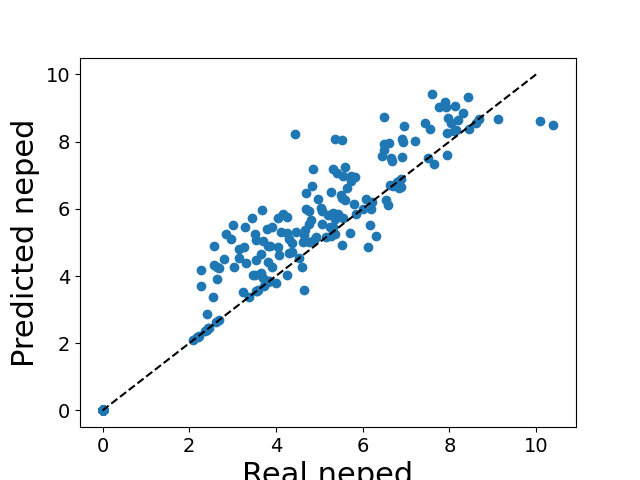

In [206]:
plt.close('all') 
# print(mean_squared_error(neped_height_mean, neped_height_real))
print(np.isinf(neped_height_real).sum(), np.isinf(neped_height_mean).sum())
print(np.isnan(neped_height_real).sum(), np.isnan(neped_height_mean).sum())
plt.scatter(neped_height_real, neped_height_mean)
plt.plot([0, 10], [0, 10], 'k--')
plt.xlabel('Real neped')
plt.ylabel('Predicted neped')

plt.show()

In [8]:
model = model_physics
# Things that don't change after training 
MP_norm, MP_var = state_dict['MP_norms']
norms_MP = MP_norm, MP_var
D_norm, D_var = state_dict['D_norms']
norms_D = D_norm, D_var
T_norm, T_var = state_dict['T_norms']
norms_T = T_norm, T_var


# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()

train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
test_mp_tensors = torch.tensor(test_y).float()
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized[:, 0] = standardize(train_profiles_normalized[:, 0], D_norm, D_var)
train_profiles_normalized[:, 1] = standardize(train_profiles_normalized[:, 1], T_norm, T_var)


test_profiles = torch.tensor(test_X).float()

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized[:, 0] = standardize(test_profiles_normalized[:, 0], D_norm, D_var)
test_profiles_normalized[:, 1] = standardize(test_profiles_normalized[:, 1], T_norm, T_var)

k = 13 # 12, 19, 29, 35, 36
"""
PULSE_1_real = train_profiles[pulse_1_idxs], train_radii[pulse_1_idxs], train_mask[pulse_1_idxs] > 0, options[0], train_mp_tensors[pulse_1_idxs]
PULSE_2_real = train_profiles[pulse_2_idxs], train_radii[pulse_2_idxs], train_mask[pulse_2_idxs] > 0, options[1], train_mp_tensors[pulse_2_idxs]

PULSE_1_profs_conditional = get_conditional_preds(PULSE_1_real, n_samples=200)
PULSE_1_profs_encoder, PULSE_1_mps_encoder = get_preds_pulse(PULSE_1_real)

PULSE_2_profs_conditional = get_conditional_preds(PULSE_2_real, n_samples=200)
PULSE_2_profs_encoder, PULSE_2_mps_encoder = get_preds_pulse(PULSE_2_real)
"""



# Z_MACH_TRAINING, Z_STOCH_TRAINING, Z_TRAINING = get_latent_space(train_profiles_normalized, model)
# PRED_MPS_FROM_Z_TRAINING_NORM, PRED_MPS_FROM_Z_TRAINING_REAL = get_mps(Z_MACH_TRAINING, model)

# Z_MACH_TRAINING_no_physics, Z_STOCH_TRAINING_no_physics, Z_TRAINING_no_physics = get_latent_space(train_profiles_normalized, model_no_physics)
# PRED_MPS_FROM_Z_TRAINING_NORM_no_physics, PRED_MPS_FROM_Z_TRAINING_REAL_no_physics = get_mps(Z_MACH_TRAINING, model_no_physics)

'\nPULSE_1_real = train_profiles[pulse_1_idxs], train_radii[pulse_1_idxs], train_mask[pulse_1_idxs] > 0, options[0], train_mp_tensors[pulse_1_idxs]\nPULSE_2_real = train_profiles[pulse_2_idxs], train_radii[pulse_2_idxs], train_mask[pulse_2_idxs] > 0, options[1], train_mp_tensors[pulse_2_idxs]\n\nPULSE_1_profs_conditional = get_conditional_preds(PULSE_1_real, n_samples=200)\nPULSE_1_profs_encoder, PULSE_1_mps_encoder = get_preds_pulse(PULSE_1_real)\n\nPULSE_2_profs_conditional = get_conditional_preds(PULSE_2_real, n_samples=200)\nPULSE_2_profs_encoder, PULSE_2_mps_encoder = get_preds_pulse(PULSE_2_real)\n'

In [ ]:
plt.close('all')
for k in range(75, 80): 
    PULSE_val_real = val_profiles[val_pulse_ids[k]], val_radii[val_pulse_ids[k]], val_mask[val_pulse_ids[k]] > 0, val_pulses[k], val_mp_tensors[val_pulse_ids[k]], val_real_space_radii[val_pulse_ids[k]]
    """
    PULSE_val_real = val_profiles[val_pulse_ids[k]], val_radii[val_pulse_ids[k]], val_mask[val_pulse_ids[k]] > 0, val_pulses[k], val_mp_tensors[val_pulse_ids[k]]
    model = model_no_physics
    PULSE_val_conditional = get_conditional_preds(PULSE_val_real, n_samples=200)
    PULSE_val_enc, MP_val_enc = get_preds_pulse(PULSE_val_real)
    neseps_1, neseps_2, teseps_1, teseps_2, psis = from_profiles_find_nesep(PULSE_val_real, (PULSE_val_conditional, PULSE_val_enc, MP_val_enc))
    
    plot_all(PULSE_val_real, (PULSE_val_conditional, PULSE_val_enc, MP_val_enc), plot_params={'id': None, 'title': None, 'model_type': 'w/o Physics', 'neseps':(neseps_1, neseps_2), 'psis':  psis, 'teseps':  (teseps_1, teseps_2)})
    """
    model = model_physics
    PULSE_val_conditional = get_conditional_preds(PULSE_val_real, n_samples=200)
    PULSE_val_enc, MP_val_enc = get_preds_pulse(PULSE_val_real)
    mean_neped, std_neped = calculate_mse_neped(PULSE_val_real, PULSE_val_conditional)
    print(mean_neped, std_neped)
    break
    # neseps_1, neseps_2, teseps_1, teseps_2, psis  = from_profiles_find_nesep(PULSE_val_real, (PULSE_val_conditional, PULSE_val_enc, MP_val_enc))
    # plot_all(PULSE_val_real, (PULSE_val_conditional, PULSE_val_enc, MP_val_enc), plot_params={'id': None, 'title': '', 'model_type': 'Physics', 'neseps':None, 'psis':  psis, 'teseps':  None, 'annotate_mparams': True})





In [ ]:
plt.close('all')

def curve_fit_for_ped_params(PROFILES, profiles_cond): 
    profiles, radii, masks, ids, mps = PROFILES 
    
    # grab parameters from Jet PDB 
    JPDB_pulse = jet_pedestal_database[jet_pedestal_database['shot'] == ids]
    
    # h1, h0, p, w, s
    initial_guesses_ne = [JPDB_pulse['nepedheight10^19(m^-3)'].values[0], 0.0,  JPDB_pulse['neposition(psiN)'].values[0],JPDB_pulse['Nepedestalwidth(psiN%)'].values[0],JPDB_pulse['neinnerslope'].values[0], ]
    initial_guesses_te = [JPDB_pulse['Tepedheight(keV)'].values[0], 0.0,  JPDB_pulse['Teposition(psiN)'].values[0],JPDB_pulse['Tepedestalwidth(psiN%)'].values[0],JPDB_pulse['Teinnerslope'].values[0], ]
    
    # conditional predictions
    d_profs_con, t_profs_con = profiles_cond[:, 0, :], profiles_cond[:, 1, :]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True, sharex=True)
    for n, (d_prof, t_prof, rad, mask) in enumerate(zip(d_profs_con, t_profs_con, radii, masks)):
        if len(JPDB_pulse) == 2: 
            continue
        xdata = rad[mask]
        xdata = np.linspace(3.75, 3.9, len(rad[mask]))
        
        xdata_fit = np.linspace(0.8, 1.1)
        xdata_fit = np.linspace(3.75, 3.9, 50)
        ydata_d = 1e-19*d_prof[mask]
        ydata_t = t_prof[mask]/ 1000.0
        
        popt_d, pcov_d = curve_fit(mtanh, xdata, ydata_d, p0 = initial_guesses_ne)
        popt_t, pcov_t = curve_fit(mtanh, xdata, ydata_t, p0 = initial_guesses_te)
        print(popt_d, popt_t)
        print(initial_guesses_ne, initial_guesses_te)
        
        axs[0].scatter(xdata, ydata_d, label='Cond_scatter') 
        axs[0].plot(xdata_fit, mtanh(xdata_fit, *initial_guesses_ne))
        print(mtanh(xdata_fit, *popt_d))
        # axs[0].plot(xdata_fit, mtanh(xdata_fit, *popt_d))
        break
    plt.show()
for k in range(58, 63):
    PULSE_val_real = val_profiles[val_pulse_ids[k]], val_radii[val_pulse_ids[k]], val_mask[val_pulse_ids[k]] > 0, val_pulses[k], val_mp_tensors[val_pulse_ids[k]]
    model = model_no_physics
    PULSE_val_conditional = get_conditional_preds(PULSE_val_real, n_samples=200)
    
    curve_fit_for_ped_params(PULSE_val_real, PULSE_val_conditional)   


In [22]:
jet_pedestal_database.columns.to_list()

['Unnamed: 0',
 'shot',
 'dda',
 't1',
 't2',
 'Tepedheight(keV)',
 'error_Tepedheight(keV)',
 'nepedheight10^19(m^-3)',
 'error_nepedheight10^19(m^-3)',
 'pepedheight(kPa)',
 'error_pepedheight(kPa)',
 'TepsiN=0.9pre-ELM(keV)',
 'error_TepsiN=0.9pre-ELM(keV)',
 'nepsiN=0.9pre-ELM10^19(m^-3)',
 'error_nepsiN=0.9pre-ELM10^19(m^-3)',
 'pepsiN=0.9pre-ELM(kPa)',
 'error_pepsiN=0.9pre-ELM(kPa)',
 'Tepedestalwidth(psiN%)',
 'error_Tepedestalwidth(psiN%)',
 'Nepedestalwidth(psiN%)',
 'error_Nepedestalwidth(psiN%)',
 'pepedestalwidth(psiN%)',
 'error_pepedestalwidth(psiN%)',
 'TepedestalwidthRmid(cm)',
 'error_TepedestalwidthRmid(cm)',
 'NepedestalwidthRmid(cm)',
 'error_NepedestalwidthRmid(cm)',
 'pepedestalwidthRmid(cm)',
 'error_pepedestalwidthRmid(cm)',
 'neseparatrixfromexpdata10^19(m^-3)',
 'error_neseparatrixfromexpdata10^19(m^-3)',
 'neseparatrixfromfit10^19(m^-3)',
 'error_neseparatrixfromfit10^19(m^-3)',
 'neposition(psiN)',
 'error_neposition(psiN)',
 'Teposition(psiN)',
 'error_Tep